
# **Semiconductor Production Planning Using Linear Optimization**
**Prepared by:** Pauline Wang (pwang7@nd.edu, 2024) and Mariam Jafri (mjafri@nd.edu, 2023)

**Primary Source:** https://mobook.github.io/MO-book/notebooks/02/01-bim.html

By the end of this project, we hope to:

*   Gain experience in defining and evaluating optimization problems manually.
*   Build skills in Python programming and using the Pyomo library.
*   Interpret and communicate findings from optimization analyses of chip production

## Preamble: Install Pyomo and a solver


We consolidated the package installation commands for pyomo and highspy into a single line and grouped the imports for improved readability, but we made no significant changes to the functionality of the original code from the original source.

In [ ]:
import sys

if 'google.colab' in sys.modules:
    %pip install pyomo highspy >/dev/null 2>/dev/null
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
    helper.install_glpk()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()

import pyomo.environ as pyo
solver = 'appsi_highs'
SOLVER = pyo.SolverFactory(solver)
assert SOLVER.available(), f"Solver {solver} is not available."

# Additional imports
import random
import numpy as np
import matplotlib.pyplot as plt
import highspy

--2024-11-01 22:21:13--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-11-01 22:21:14 (66.0 MB/s) - ‘helper.py’ saved [6493/6493]

Installing idaes via pip...
idaes was successfully installed
idaes, version 2.6.0


Running idaes get-extensions to install Ipopt, k_aug, and more...
Checking solver versions:
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)



[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)



Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimiz

## The microchip production problem

### Problem description
The company BIM (Best International Machines) produces two types of microchips, logic chips (1g silicon, 1g plastic, 4g copper) and memory chips (1g germanium, 1g plastic, 2g copper). Each of the logic chips can be sold for a 12€ profit, and each of the memory chips for a 9€ profit. The current stock of raw materials.





## Building the optimization problem
Let $x \geq 0$ denote the number of logic chips to be produced and $y \geq 0$ the number of memory chips. In the problem described above, the goal is to maximize the total profit. Since for each logic chip the profit is 12 euro, and for each memory chip it is 9 euro, the total profit to maximize is equal to

$$
    12x + 9y.
$$

In maximizing this quantity, we have to respect some constraints. We know that we cannot use more raw materials than those are available in stock.

For copper, this means that the joint usage for logic chips, which is equal to $4x$ g (4g per chip for each of the $x$ chips), and for memory chips, which is equal to $2y$ g (2g per chip for each of the $y$ chips), cannot exceed the maximum availability of 4800g of copper:

$$
    4x + 2y \leq 4800.
$$

Similarly, we can deduce the condition for silicon, which involves only logic chips (note that memory chips do not require this element),

$$
    x \leq 1000,
$$

the condition for germanium, which involves only memory chips (note that logic chips do not require this element),

$$
    y \leq 1500,
$$

and the condition for plastic, which involves both types of chips,

$$
    x + y \leq 1750.
$$


This decision can be reformulated as an optimization problem of the following form:

$$
\begin{align*}
\max \quad & 12x + 9y \\
\text{s.t.} \quad & x \leq 1000 \quad \text{(silicon)} \\
                 & y \leq 1500 \quad \text{(germanium)} \\
                 & x + y \leq 1750 \quad \text{(plastic)} \\
                 & 4x + 2y \leq 4800 \quad \text{(copper)} \\
                 & x, y \geq 0 \\
\end{align*}
$$


Leveraging the fact that we have a two-dimensional problem, we can then visualize the entire feasible region.

<div align="center">

![svg image](../../media/BIM_feasibleregion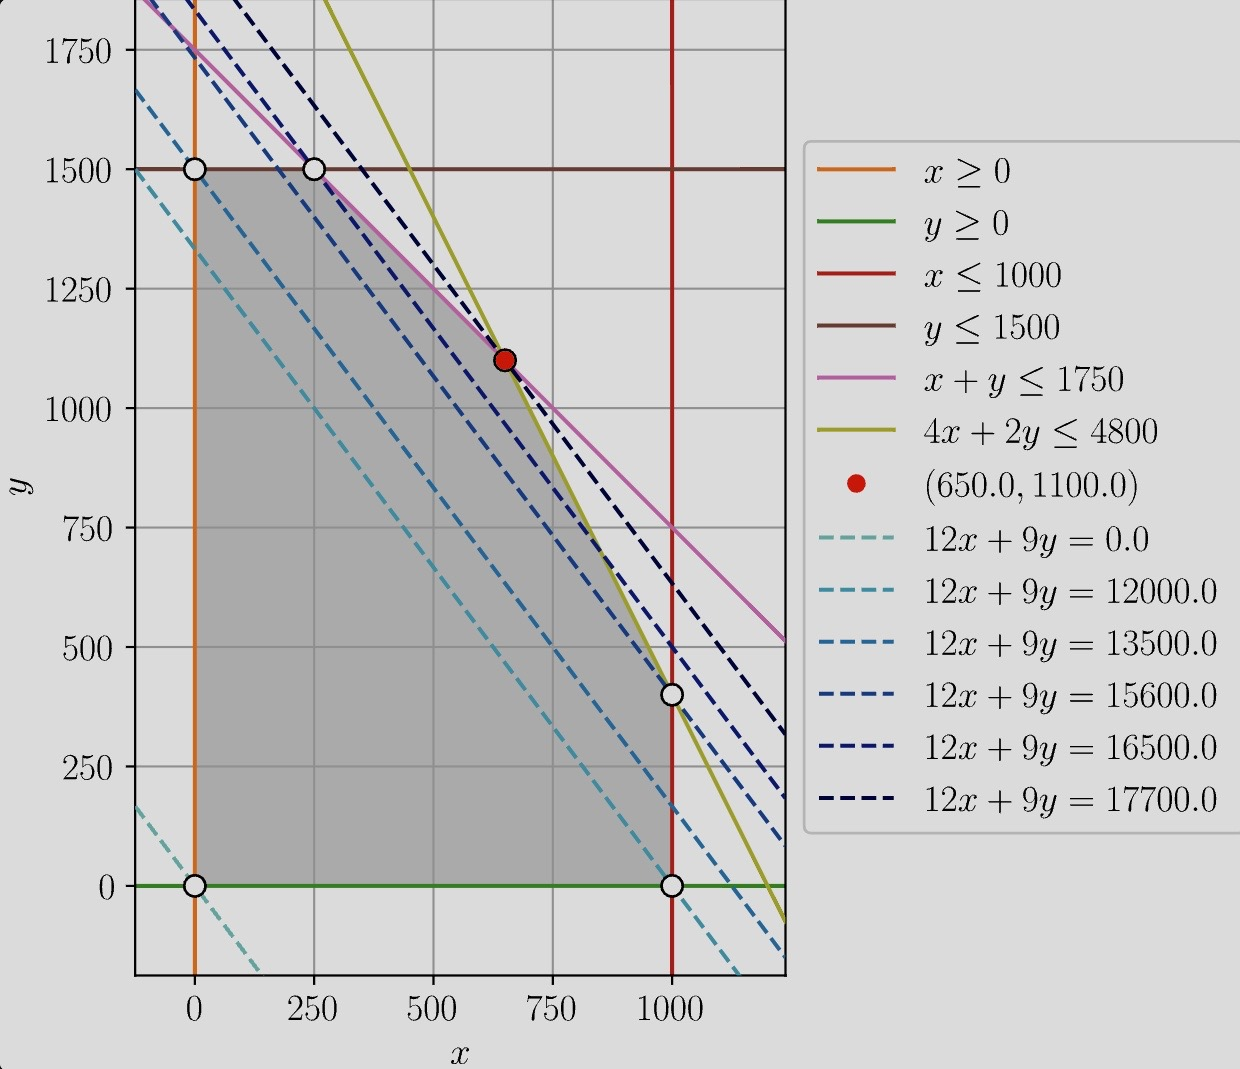.svg)

</div>

The feasible region is displayed in gray, enclosed by the linear constraints (solid lines). The isolines corresponding to the objective function are displayed as parallel dashed blue lines with increasing color intensity when the objective function value is larger. We can intuitively already guess the optimal solution, which is marked with a red dot.

## Matrix reformulation of the BIM problem

This problem is relatively small, featuring only $n=2$ decision variables and $m=4$ constraints. Therefore, we decided to add additional three constraints: environmental cost constraint, buyer demand constraint, and quality control constraint. The environmental cost constraint stipulates that each chip produced incurs an environmental cost. Therefore, the total environmental cost, defined as the product of the number of chips and the cost per chip, must not exceed a predetermined maximum. The buyer demand constraint operates as a binary system: a binary value of 0 indicates market preference for logic chips, whereas a binary value of 1 indicates market preference for memory chips. When the parameter alpha equals 0, the optimization will prioritize the production of logic chips; conversely, when alpha equals 1, the optimization will prioritize memory chip production. The quality constraint in this optimization problem assumes that at least 80% of the total manufactured chips are functional and usable, thereby limiting the proportion of defective units to a maximum of 20%. In this project, we aim to determine the optimal number of microchips of each type that should be produced to maximize profit, while respecting the constraints of raw material availability, enviornmental cost, buyer demand, and quality control.

The environmental cost constraint is:

$$
C_{\text{logic}} \cdot x + C_{\text{memory}} \cdot y \leq E_{\text{max}}
$$


Where:
- $C_{\text{logic}}$  and $C_{\text{memory}}$ are the environmental costs per logic and memory chip, respectively.
- $E_{\text{max}}$ is the maximum allowed total environmental cost.



The buyer demand constraint operates as a binary system:

$$
\alpha \in \{0, 1\}
$$

Where:
- $\alpha$ = 0 indicates a market preference for logic chips.
- $\alpha$ = 1 indicates a market preference for memory chips.

The quality control constraint ensures that at least 80% of the produced chips are functional. The constraint can be written as:

$$
0.8(x + y) \leq \text{Total functional chips}
$$

Alternatively, the number of defective chips is restricted to 20% of total production:

$$
0.2(x + y) \leq \text{Max defective chips}
$$

Where:
- x is the number of logic chips.
- y is the number of memory chips.

As a first step towards building a vector-matrix formulation of our problem, we rename the decision variables x and y, as x1 and x2, obtaining:


$$
\begin{align*}
\max \quad & 12x + 9y \\
\text{s.t.} \quad & x \leq 1000 \quad \text{(silicon)} \\
                 & y \leq 1500 \quad \text{(germanium)} \\
                 & x + y \leq 1750 \quad \text{(plastic)} \\
                 & 4x + 2y \leq 4800 \quad \text{(copper)} \\
                 & x, y \geq 0 \\
                 & C_{\text{logic}} \cdot x + C_{\text{memory}} \cdot y \leq E_{\text{max}} \quad \text{(environmental cost)} \\
                 & 0.2(x + y) \leq \text{Max defective chips} \quad \text{(quality control)} \\
                 & \alpha \in \{0,1\} \quad \text{(buyer demand)}
\end{align*}
$$


Denote the vector of decision variables by $x = \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}$, where $x_1$ and $x_2$ are just the respective components.

We now rewrite the objective function using the vector form. For this, we define the vector

$$
\begin{align*}
    c = \begin{pmatrix} 12 \\ 9 \end{pmatrix}
\end{align*}
$$

so that the objective

$$
\begin{align*}
\max \ c^\top x = \max \ 12x_1 +9x_2.
\end{align*}
$$

For the constraints, we define the problem coefficients as

$$
\begin{align*}
    A =
    \begin{bmatrix}
    1 & 0\\
    0 & 1\\
    1 & 1\\
    4 & 2\\
    \end{bmatrix},
    \quad \text{ and } \quad
    b = \begin{pmatrix} 1000 \\ 1500 \\ 1750 \\ 4800 \end{pmatrix}.
\end{align*}
$$

The system of inequalities $A x \geq b$, when read row-by-row, correctly replicates all the constraints:

$$
\begin{align*}
A x = \begin{bmatrix}
x_1 \\
x_2 \\
x_1 + x_2 \\
4x_1 + 2 x_2
\end{bmatrix} \leq \begin{pmatrix} 1000 \\ 1500 \\ 1750 \\ 4800 \end{pmatrix} = b
\quad \Longleftrightarrow \quad
\left\{
\begin{array}{l}
x_1 \leq 1000 \\
x_2 \leq 1500 \\
x_1 + x_2 \leq 1750 \\
4x_1 + 2x_2 \leq 4800.
\end{array}
\right.
\end{align*}
$$

In this way, our optimization problem becomes:

$$
\begin{align*}
    \max \quad & c^\top x\\
    \text{s.t.} \quad & A x \leq b \\
    & x \in \mathbb{R}_{+}^2.
\end{align*}
$$

This model can be implemented and solved using Pyomo as follows.

In [ ]:
import pyomo.environ as pyo

def m_model(env_x1=4, env_x2=3, defects=0.97, demand=0):
    """
    Build and solve an optimization model for BIM production planning with environmental, quality, and demand constraints.

    Parameters:
    - env_x1 (float): Environmental cost coefficient for logic chips.
    - env_x2 (float): Environmental cost coefficient for memory chips.
    - defects (float): Proportion of defective chips allowed in the quality constraint.
    - demand (int): Demand flag (0 or 1) indicating buyer preference for chip types.
                    If `demand=1`, demand favors logic chips, requiring logic production
                    (x1) >= memory production (x2). If `demand=0`, demand favors memory
                    chips, requiring memory production (x2) >= logic production (x1).

    Decision Variables:
    - x1: Number of logic chips produced (non-negative).
    - x2: Number of memory chips produced (non-negative).

    Objective:
    - Maximize profit, calculated as 12 * x1 + 9 * x2.

    Constraints:
    - Silicon constraint: x1 <= 1000 (maximum availability of silicon for logic chips).
    - Germanium constraint: x2 <= 1500 (maximum availability of germanium for memory chips).
    - Plastic constraint: x1 + x2 <= 1750 (combined plastic limit for both chips).
    - Copper constraint: 4 * x1 + 2 * x2 <= 4800 (maximum copper usage).
    - Environmental cost constraint: env_x1 * x1 + env_x2 * x2 <= 10000 (total environmental impact limit).
    - Buyer demand constraint: Enforced based on `demand` parameter; requires x1 >= x2 or x1 <= x2.
    - Quality control constraint: defects * (x1 + x2) >= 1000, ensuring minimum functionality requirements.

    Returns:
    - model: The Pyomo ConcreteModel instance containing the defined objective and constraints.

    Prints:
    - Solution for x1 and x2, optimal profit value, environmental constraint coefficients, demand type, and quality constraint values.
    """

    model = pyo.ConcreteModel("BIM production planning")

    # Decision variables and their domains
    model.x1 = pyo.Var(domain=pyo.NonNegativeReals)
    model.x2 = pyo.Var(domain=pyo.NonNegativeReals)

    model.env_x1 = pyo.Param(initialize=env_x1)
    model.env_x2 = pyo.Param(initialize=env_x2)
    model.defects = pyo.Param(initialize=defects)
    model.demand = pyo.Param(initialize=demand)

    # Objective function
    model.profit = pyo.Objective(expr=12 * model.x1 + 9 * model.x2, sense=pyo.maximize)

    # Constraints
    model.silicon = pyo.Constraint(expr=model.x1 <= 1000)
    model.germanium = pyo.Constraint(expr=model.x2 <= 1500)
    model.plastic = pyo.Constraint(expr=model.x1 + model.x2 <= 1750)
    model.copper = pyo.Constraint(expr=4 * model.x1 + 2 * model.x2 <= 4800)

    # Environmental Constraint
    model.env = pyo.Constraint(expr=model.env_x1 * model.x1 + model.env_x2 * model.x2 <= 10000)

    # Buyer demand constraint
    if demand == 1:
        print("Demand for logic chips\n")
        model.buyer = pyo.Constraint(expr=model.x1 >= model.x2)
    else:
        print("Demand for memory chips\n")
        model.buyer = pyo.Constraint(expr=model.x1 <= model.x2)

    # Quality Constraint
    model.quality = pyo.Constraint(expr=model.defects * model.x1 + model.defects * model.x2 >= 1000)

    # Solve and print solution
    solver = pyo.SolverFactory('glpk')  # Using GLPK as an example; replace with your preferred solver
    solver.solve(model)

    print(f"x = ({model.x1.value:.1f}, {model.x2.value:.1f})")
    print(f"Optimal value = {pyo.value(model.profit):.1f}")
    print(f"Env constraint 1 = {pyo.value(model.env_x1):.1f}")
    print(f"Env constraint 2 value = {pyo.value(model.env_x2):.1f}")
    print(f"Demand value = {pyo.value(model.demand):.1f}")
    print(f"Quality value = {pyo.value(model.defects):.1f}")

    return model


In [ ]:
m = m_model()
print(m)

Demand for memory chips

x = (650.0, 1100.0)
Optimal value = 17700.0
Env constraint 1 = 4.0
Env constraint 2 value = 3.0
Demand value = 0.0
Quality value = 1.0
BIM production planning


## Vizualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo

def m_visualize(env_x1=0, env_x2=0, defects=0.99, demand=0):
    """
    Visualize the constraints and solution for the semiconductor production planning optimization model.

    Parameters:
    - env_x1 (float): Environmental cost coefficient for logic chips, used in environmental constraint.
    - env_x2 (float): Environmental cost coefficient for memory chips, used in environmental constraint.
    - defects (float): Proportion of defective chips allowed in the quality constraint.
    - demand (int): Demand flag (0 or 1) indicating buyer preference for chip types.
                    If `demand=1`, demand favors logic chips, requiring logic production
                    (x1) >= memory production (x2). If `demand=0`, demand favors memory
                    chips, requiring memory production (x2) >= logic production (x1).

    Workflow:
    1. Builds the BIM production planning model using `m_model` with the provided parameters.
    2. Prepares x and y values for plotting the constraint boundaries in the chip production space.
    3. Plots the following constraints:
        - Silicon constraint: Vertical line at x = 1000.
        - Germanium constraint: Horizontal line at y = 1500.
        - Plastic constraint: Line representing x + y <= 1750.
        - Copper constraint: Line representing 4 * x + 2 * y <= 4800.
        - Environmental constraint: Line dependent on `env_x1` and `env_x2`.
        - Demand constraint: Fills area based on buyer demand for either memory or logic chips.
        - Quality constraint: Line based on minimum functional chips required, dependent on `defects`.
    4. Plots the optimal solution point from the model.
    5. Adds visual elements, including axes labels, title, grid, and legend.

    Returns:
    - model: The Pyomo ConcreteModel instance with the solution point visualized on the plot.

    Displays:
    - A plot showing constraint boundaries, feasible regions, demand areas, and the solved optimal production point for logic and memory chips.
    """
    model = m_model(env_x1, env_x2, defects, demand)

    # Step 2: Prepare your data
    x = np.linspace(0, 1500, 250)  # x values from 0 to 1500
    y = np.linspace(0, 1500, 250)  # y values from 0 to 1500

    # Step 3: Create the plot
    plt.figure(figsize=(4, 6.4), dpi=300)  # Set the figure size

    # Plot the lines for y = 0 (x-axis) and x = 0 (y-axis)
    plt.plot([0, 1500], [0, 0], color='black', linewidth=3, label='Minimum chips')  # x-axis
    plt.plot([0, 0], [0, 1500], color='black', linewidth=3, label='Minimum chips')  # y-axis
    plt.plot([1000, 1000], [0, 1500], color='green', linewidth=3, label='Silicon')  # vertical line at x = 1000
    plt.plot([0, 1500], [1500, 1500], color='purple', linewidth=3, label='Germanium')  # vertical line at y = 1500
    plt.plot(x, 1750 - x, color='blue', linewidth=3, label='Plastic')
    plt.plot(x, 2400 - 2 * x, color='yellow', linewidth=3, label='Copper')

    # NEW CONSTRAINTS
    plt.plot(x, y, color='pink', linewidth=3, label='Demand')
    if model.demand == 0:  # Demand for memory chips; fill up x2 > x1
        plt.fill_between(x, y, np.max(y), color='pink', alpha=0.3, label='Memory Chips Demand')
    else:
        plt.fill_between(x, y, color='pink', alpha=0.3, label='Logic Chips Demand')

    # Environmental constraint
    plt.plot(x, (10000 - model.env_x1 * x) / model.env_x2, color='orange', linewidth=3, label='Environmental')
    # Quality constraint
    plt.plot(x, 1000 / model.defects - x, color='red', linewidth=3, label='Quality')

    # Plot the solution point
    plt.plot(model.x1.value, model.x2.value, marker='o', markersize=8, color='red', label='Solved point')

    # Plot settings
    plt.tick_params(axis='both', which='major', labelsize=15, direction='in')
    plt.tick_params(axis='both', which='minor', labelsize=15, direction='in')
    plt.minorticks_on()
    plt.xlim(-50, 1500)                # Set x-axis limits
    plt.ylim(-50, 1500)                # Set y-axis limits
    plt.title('BIM Production Planning')  # Title of the plot
    plt.xlabel('Logic Chips', fontsize=16, fontweight='bold')  # x-axis label
    plt.ylabel('Memory Chips', fontsize=16, fontweight='bold')  # y-axis label
    plt.axhline(0, color='black', linewidth=0.5, ls='--')  # x-axis line
    plt.axvline(0, color='black', linewidth=0.5, ls='--')  # y-axis line
    plt.axvline(1000, color='black', linewidth=0.5, ls='--')  # Dashed line at x = 1000
    plt.grid(True)  # Show grid
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Step 4: Display the plot
    plt.show()

    return model

## Base Case

Demand for logic chips

x = (800.0, 800.0)
Optimal value = 16800.0
Env constraint 1 = 3.0
Env constraint 2 value = 4.0
Demand value = 1.0
Quality value = 1.0


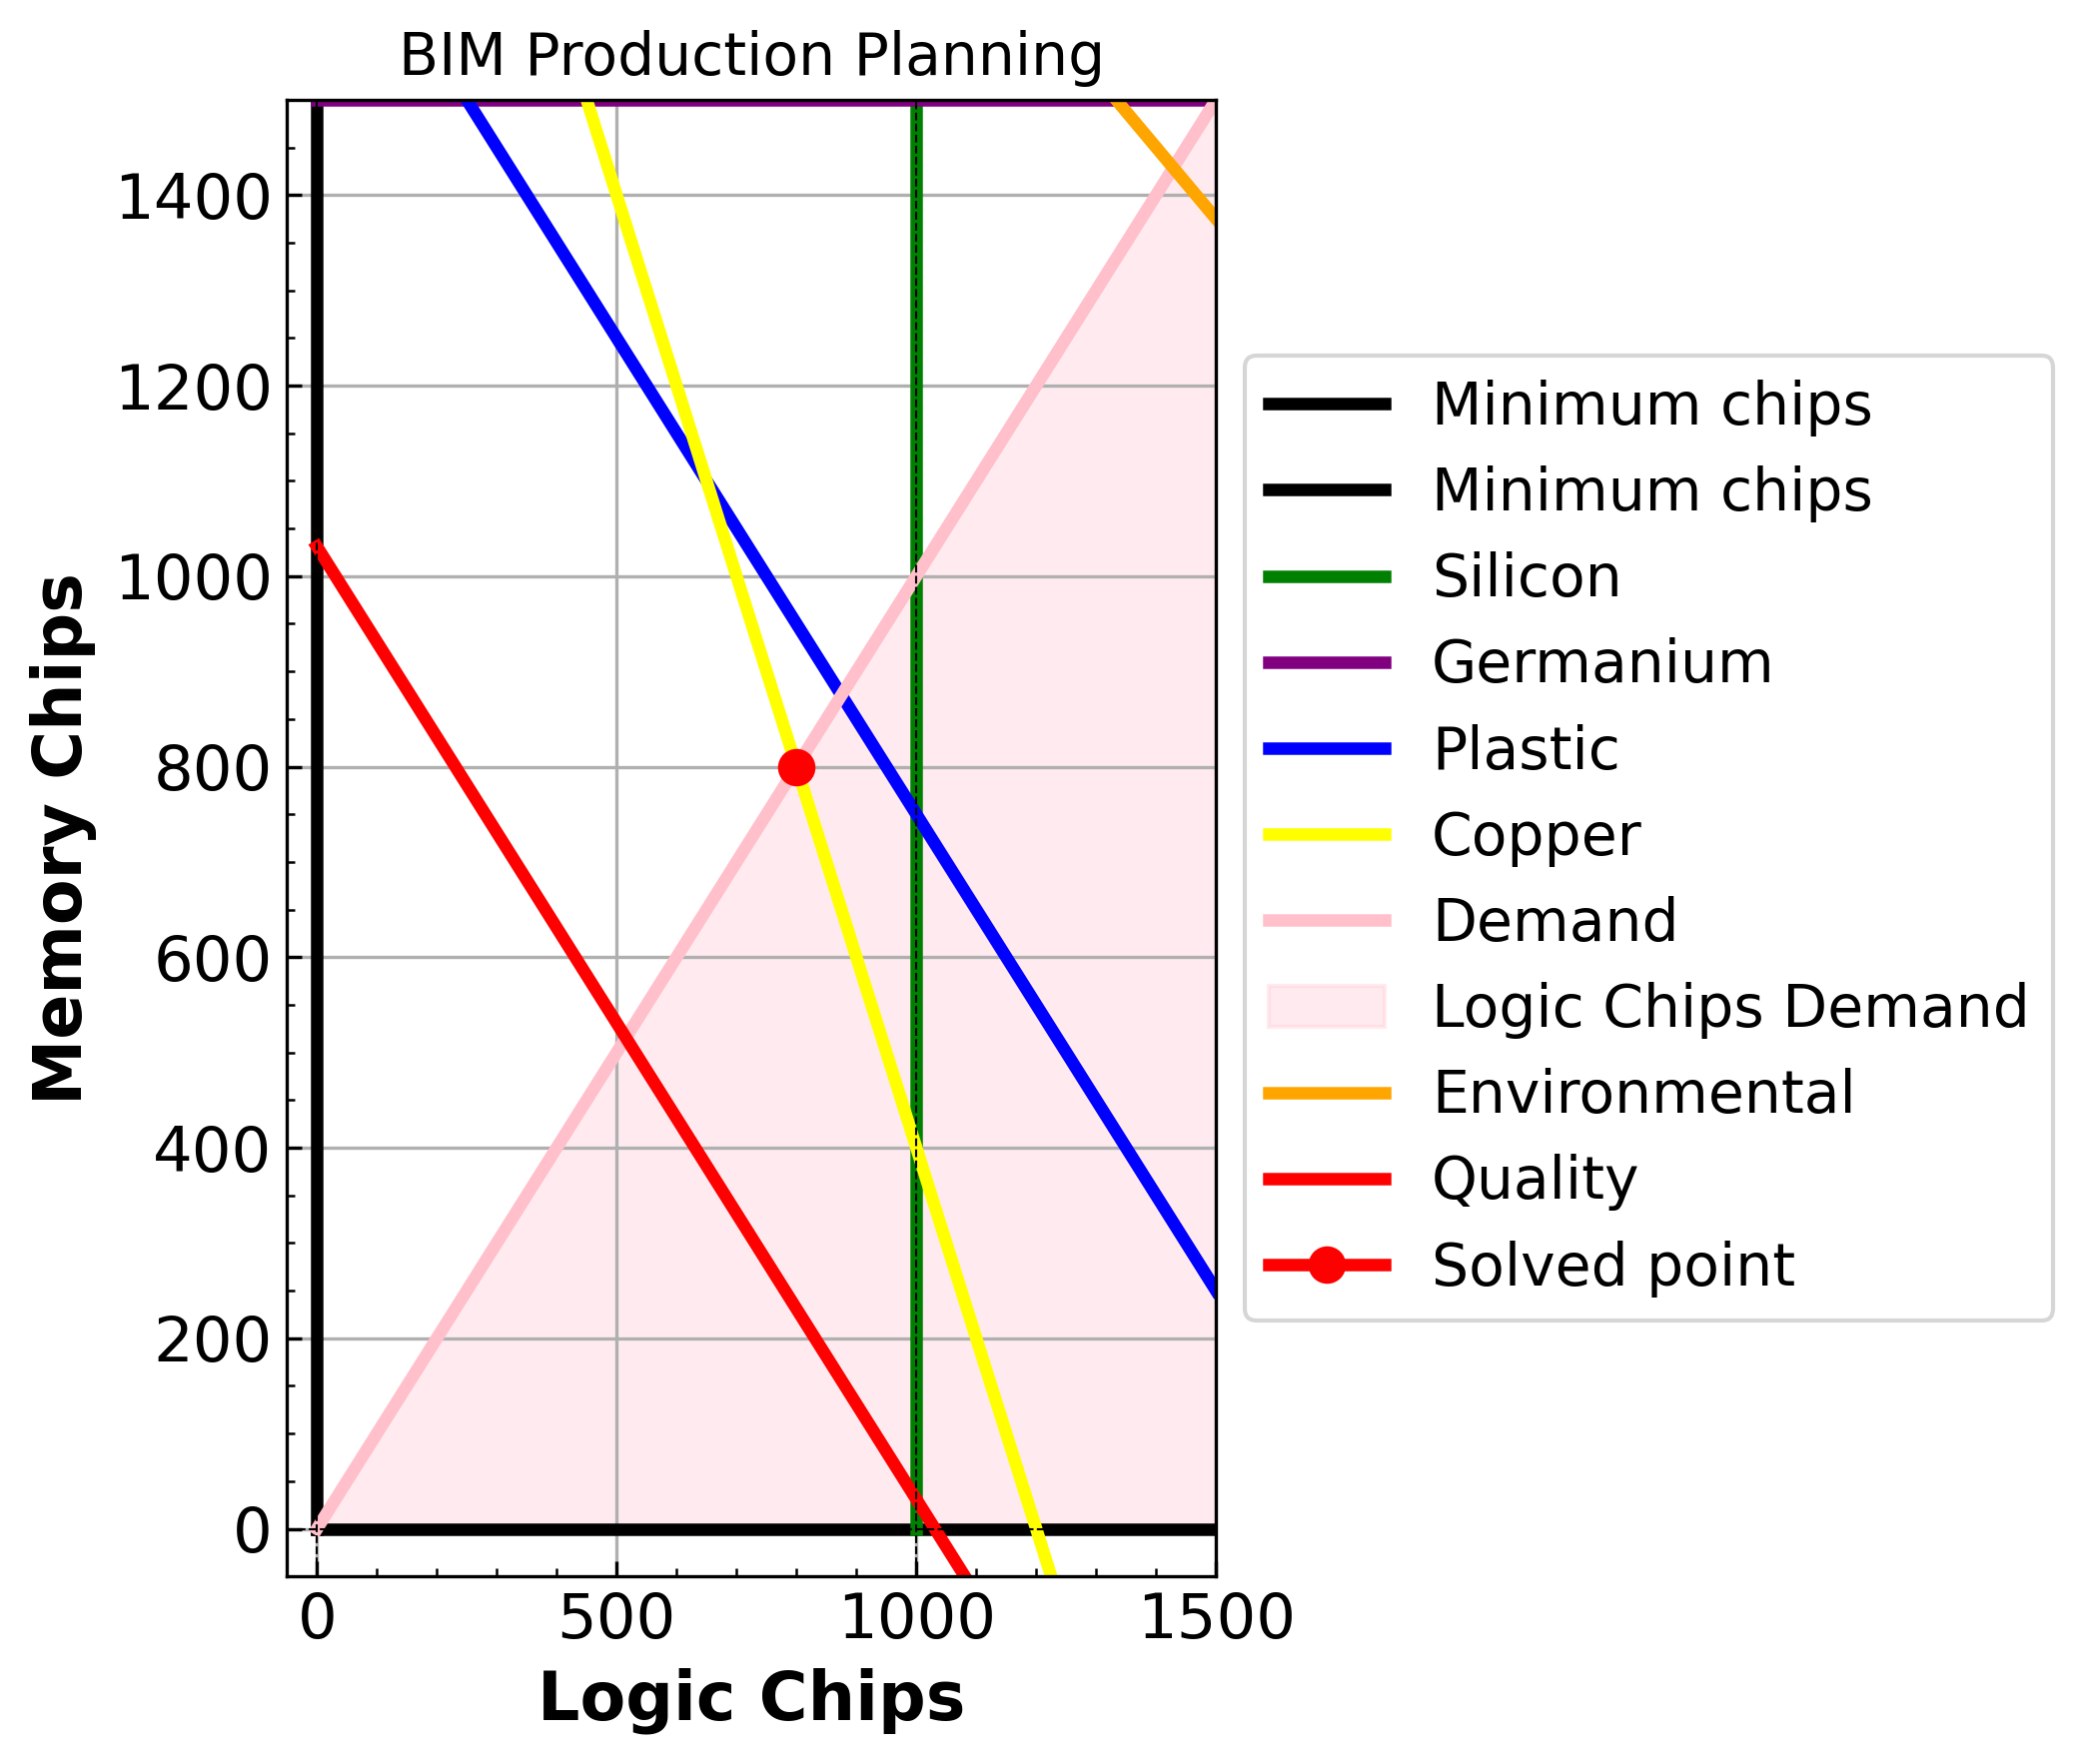

In [ ]:
m_visualize(3,4,0.97,1)

In the base case, the optimal production plan yields 800 logic chips and 800 memory chips, resulting in a maximum profit of 16,800. This solution satisfies several constraints: environmental costs for logic and memory chips (3 and 4, respectively), demand favoring logic chips, and a quality requirement ensuring all produced chips are functional. The visual representation shows that the solution lies within the feasible region defined by these constraints, with the demand constraint ensuring that logic chip production is at least equal to memory chip production.

## Insights

### Sensitivity Analysis

Demand for logic chips

x = (800.0, 800.0)
Optimal value = 16800.0
Env constraint 1 = 4.0
Env constraint 2 value = 3.0
Demand value = 1.0
Quality value = 1.0


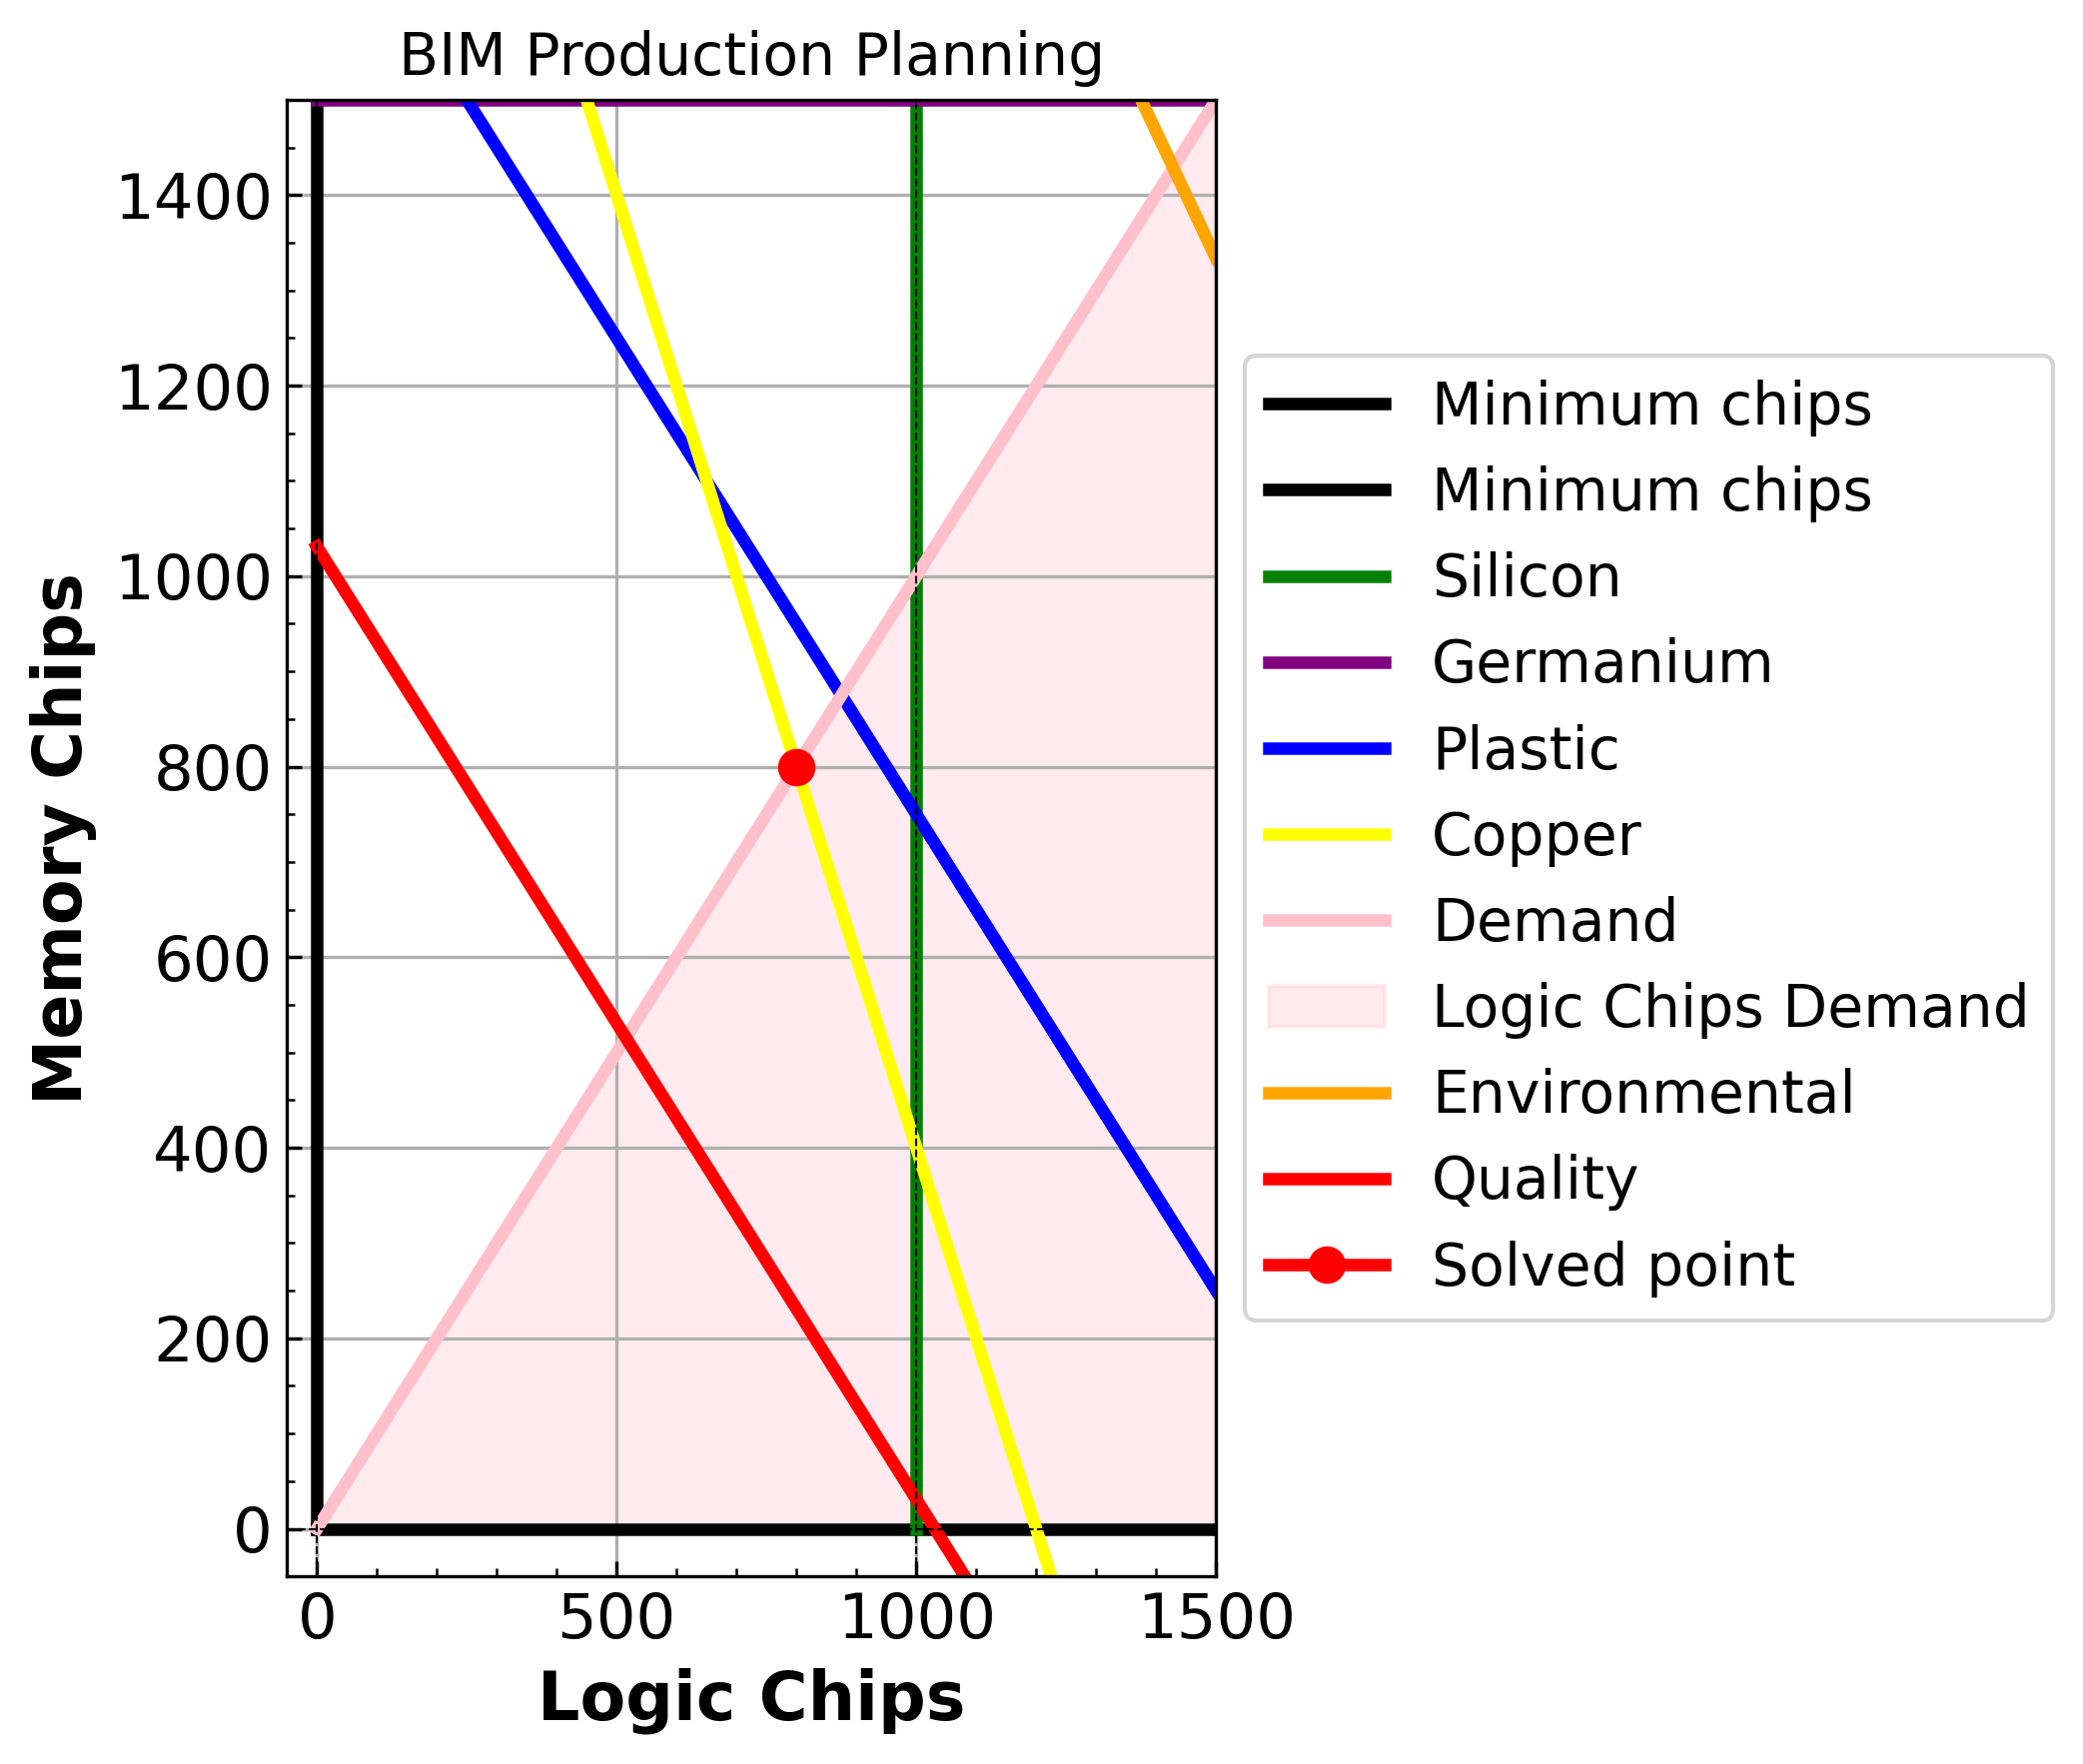


Interpretation of the static figure:
The plot shows the feasible production region for logic and memory chips based on constraints like available materials (silicon, germanium, plastic, and copper), environmental costs, and buyer demand. The demand constraint fills different areas based on demand for either logic or memory chips. The quality constraint ensures that the number of defective chips remains below a specified threshold, while the environmental constraint imposes a limit on the overall environmental cost. The red dot indicates the optimal production point, balancing profit with constraints.


In [ ]:
import ipywidgets as widgets
from IPython.display import display

#Static visualization with specific values
def static_visualization():
    """
    Calls m_visualize with specific values for environmental constraints, defects, and demand.
    Displays the static plot and provides an interpretation of the result.
    """
    #Static values for visualization
    env_x1 = 4
    env_x2 = 3
    defects = 0.97
    demand = 1

    #Call the visualization function with static values
    model = m_visualize(env_x1, env_x2, defects, demand)

    #Interpretation of the figure
    print("\nInterpretation of the static figure:")
    print("The plot shows the feasible production region for logic and memory chips "
          "based on constraints like available materials (silicon, germanium, plastic, and copper), "
          "environmental costs, and buyer demand. The demand constraint fills different areas "
          "based on demand for either logic or memory chips. The quality constraint ensures "
          "that the number of defective chips remains below a specified threshold, while "
          "the environmental constraint imposes a limit on the overall environmental cost. "
          "The red dot indicates the optimal production point, balancing profit with constraints.")


static_visualization()

The static plot shows the feasible region for producing logic and memory chips, given constraints on materials, quality, demand, and environmental impact. With `env_x1 = 4` and `env_x2 = 3`, the environmental constraint is non-binding, meaning it does not limit production within this scenario. The quality constraint, with `defects = 0.97`, and a demand preference for logic chips (`demand = 1`) shape the feasible region by enforcing a minimum number of functional chips and favoring logic production over memory. The red dot represents the optimal production point that maximizes profit while adhering to these constraints.

In [ ]:
#Interactive widget setup
def interactive_visualization():
    """
    Sets up interactive widgets to dynamically adjust the parameters of the m_visualize function.
    Displays the visualization interactively based on user-selected input values.
    """
    #Define widgets for each parameter
    env_x1_slider = widgets.FloatSlider(value=4, min=0, max=10, step=0.1, description='Env X1')
    env_x2_slider = widgets.FloatSlider(value=3, min=0, max=10, step=0.1, description='Env X2')
    defects_slider = widgets.FloatSlider(value=0.97, min=0.8, max=1.0, step=0.01, description='Defects')
    demand_toggle = widgets.ToggleButtons(options=[0, 1], description='Demand', button_style='info')

    #Use interactive output to update visualization based on widget values
    output = widgets.interactive_output(
        m_visualize,
        {
            'env_x1': env_x1_slider,
            'env_x2': env_x2_slider,
            'defects': defects_slider,
            'demand': demand_toggle
        }
    )

    #Display widgets and interactive output
    display(env_x1_slider, env_x2_slider, defects_slider, demand_toggle, output)



interactive_visualization()

FloatSlider(value=4.0, description='Env X1', max=10.0)

FloatSlider(value=3.0, description='Env X2', max=10.0)

FloatSlider(value=0.97, description='Defects', max=1.0, min=0.8, step=0.01)

ToggleButtons(button_style='info', description='Demand', options=(0, 1), value=0)

Output()

**Environmental Constraint**

Demand for memory chips

x = (733.3, 933.3)
Optimal value = 17200.0
Env constraint 1 = 6.0
Env constraint 2 value = 6.0
Demand value = 0.0
Quality value = 1.0


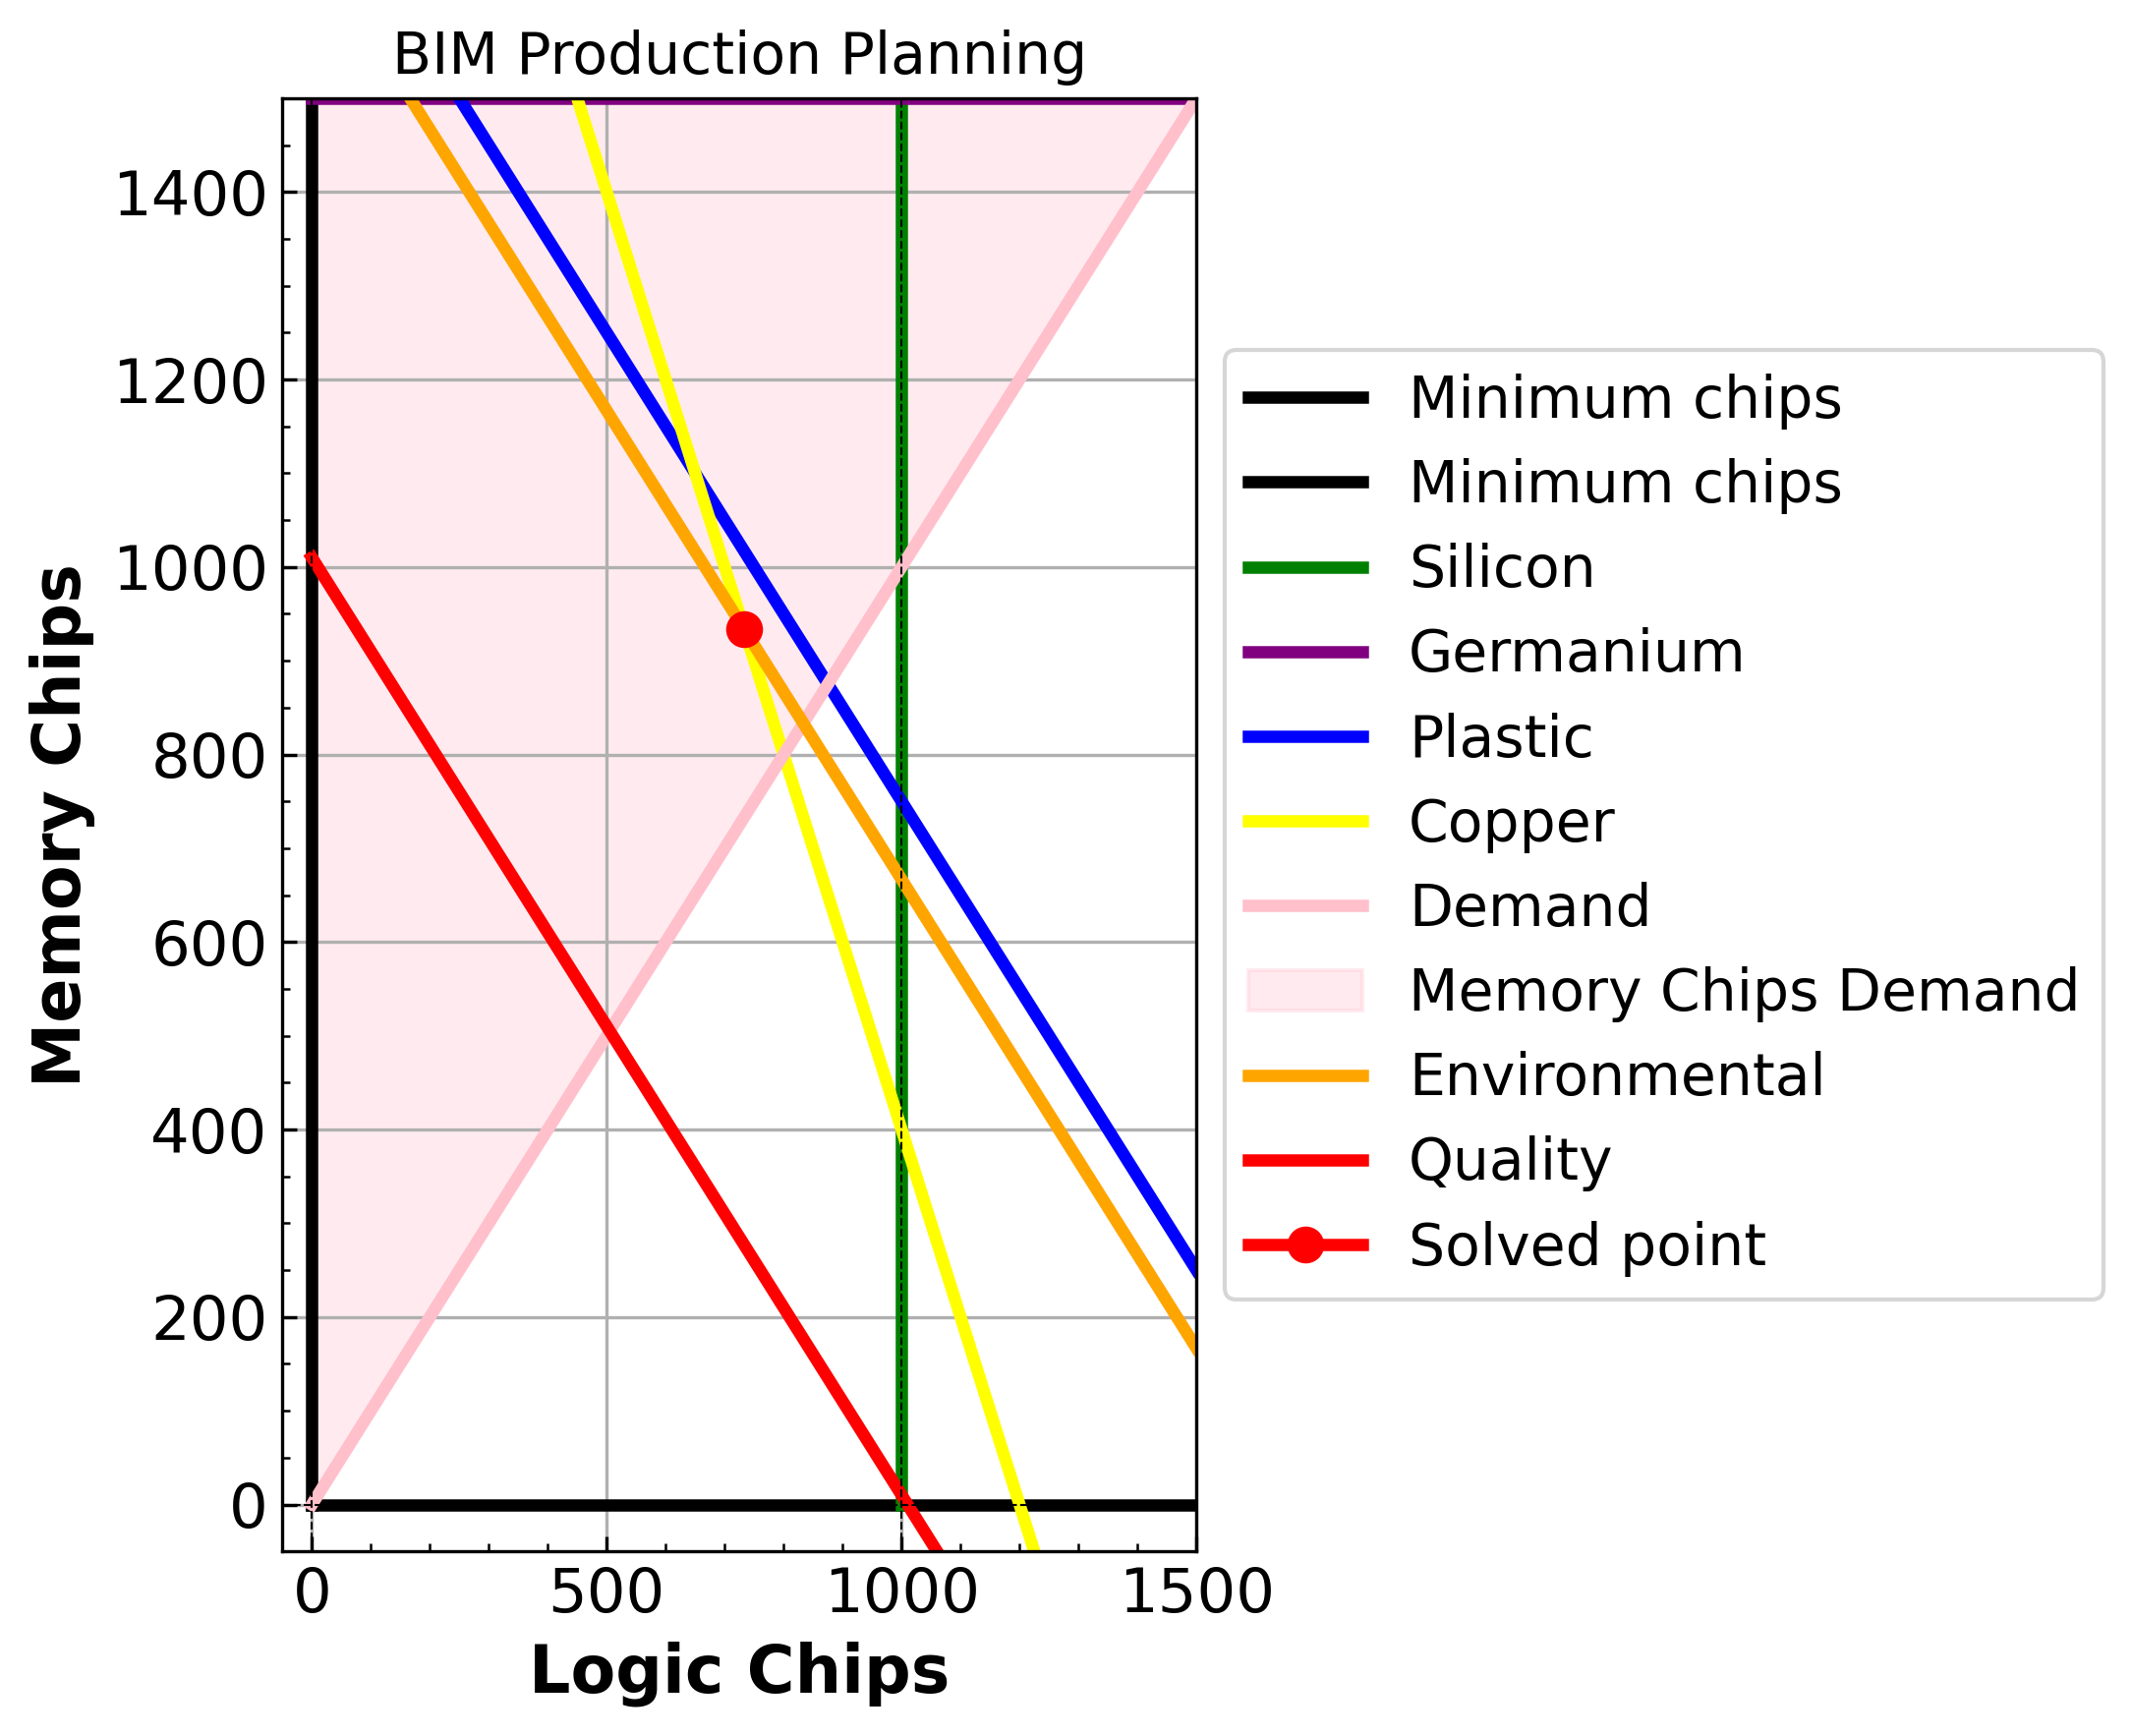

In [ ]:
m_visualize(env_x1=6, env_x2=6, defects=0.99, demand=0)


The constraint is inactive until both environmental cost values for
𝑥1 and x2 reach 6. This means that at lower values (less than 6), the environmental constraint is not binding, and the optimal solution is determined purely by other constraints (material limits, quality control, and demand). In terms of sensitivity analysis, before the environmental cost reaches 6, the system does not "feel" the impact of this constraint, as the optimal point remains in a region where this constraint is non-binding.
At higher environmental cost values, the system starts to restrict the feasible region more significantly, potentially leading to reduced profits or shifts in the balance of logic versus memory chip production to comply with the environmental threshold.



**Buyer Demand Constraint**


Demand for memory chips

x = (650.0, 1100.0)
Optimal value = 17700.0
Env constraint 1 = 4.0
Env constraint 2 value = 3.0
Demand value = 0.0
Quality value = 1.0


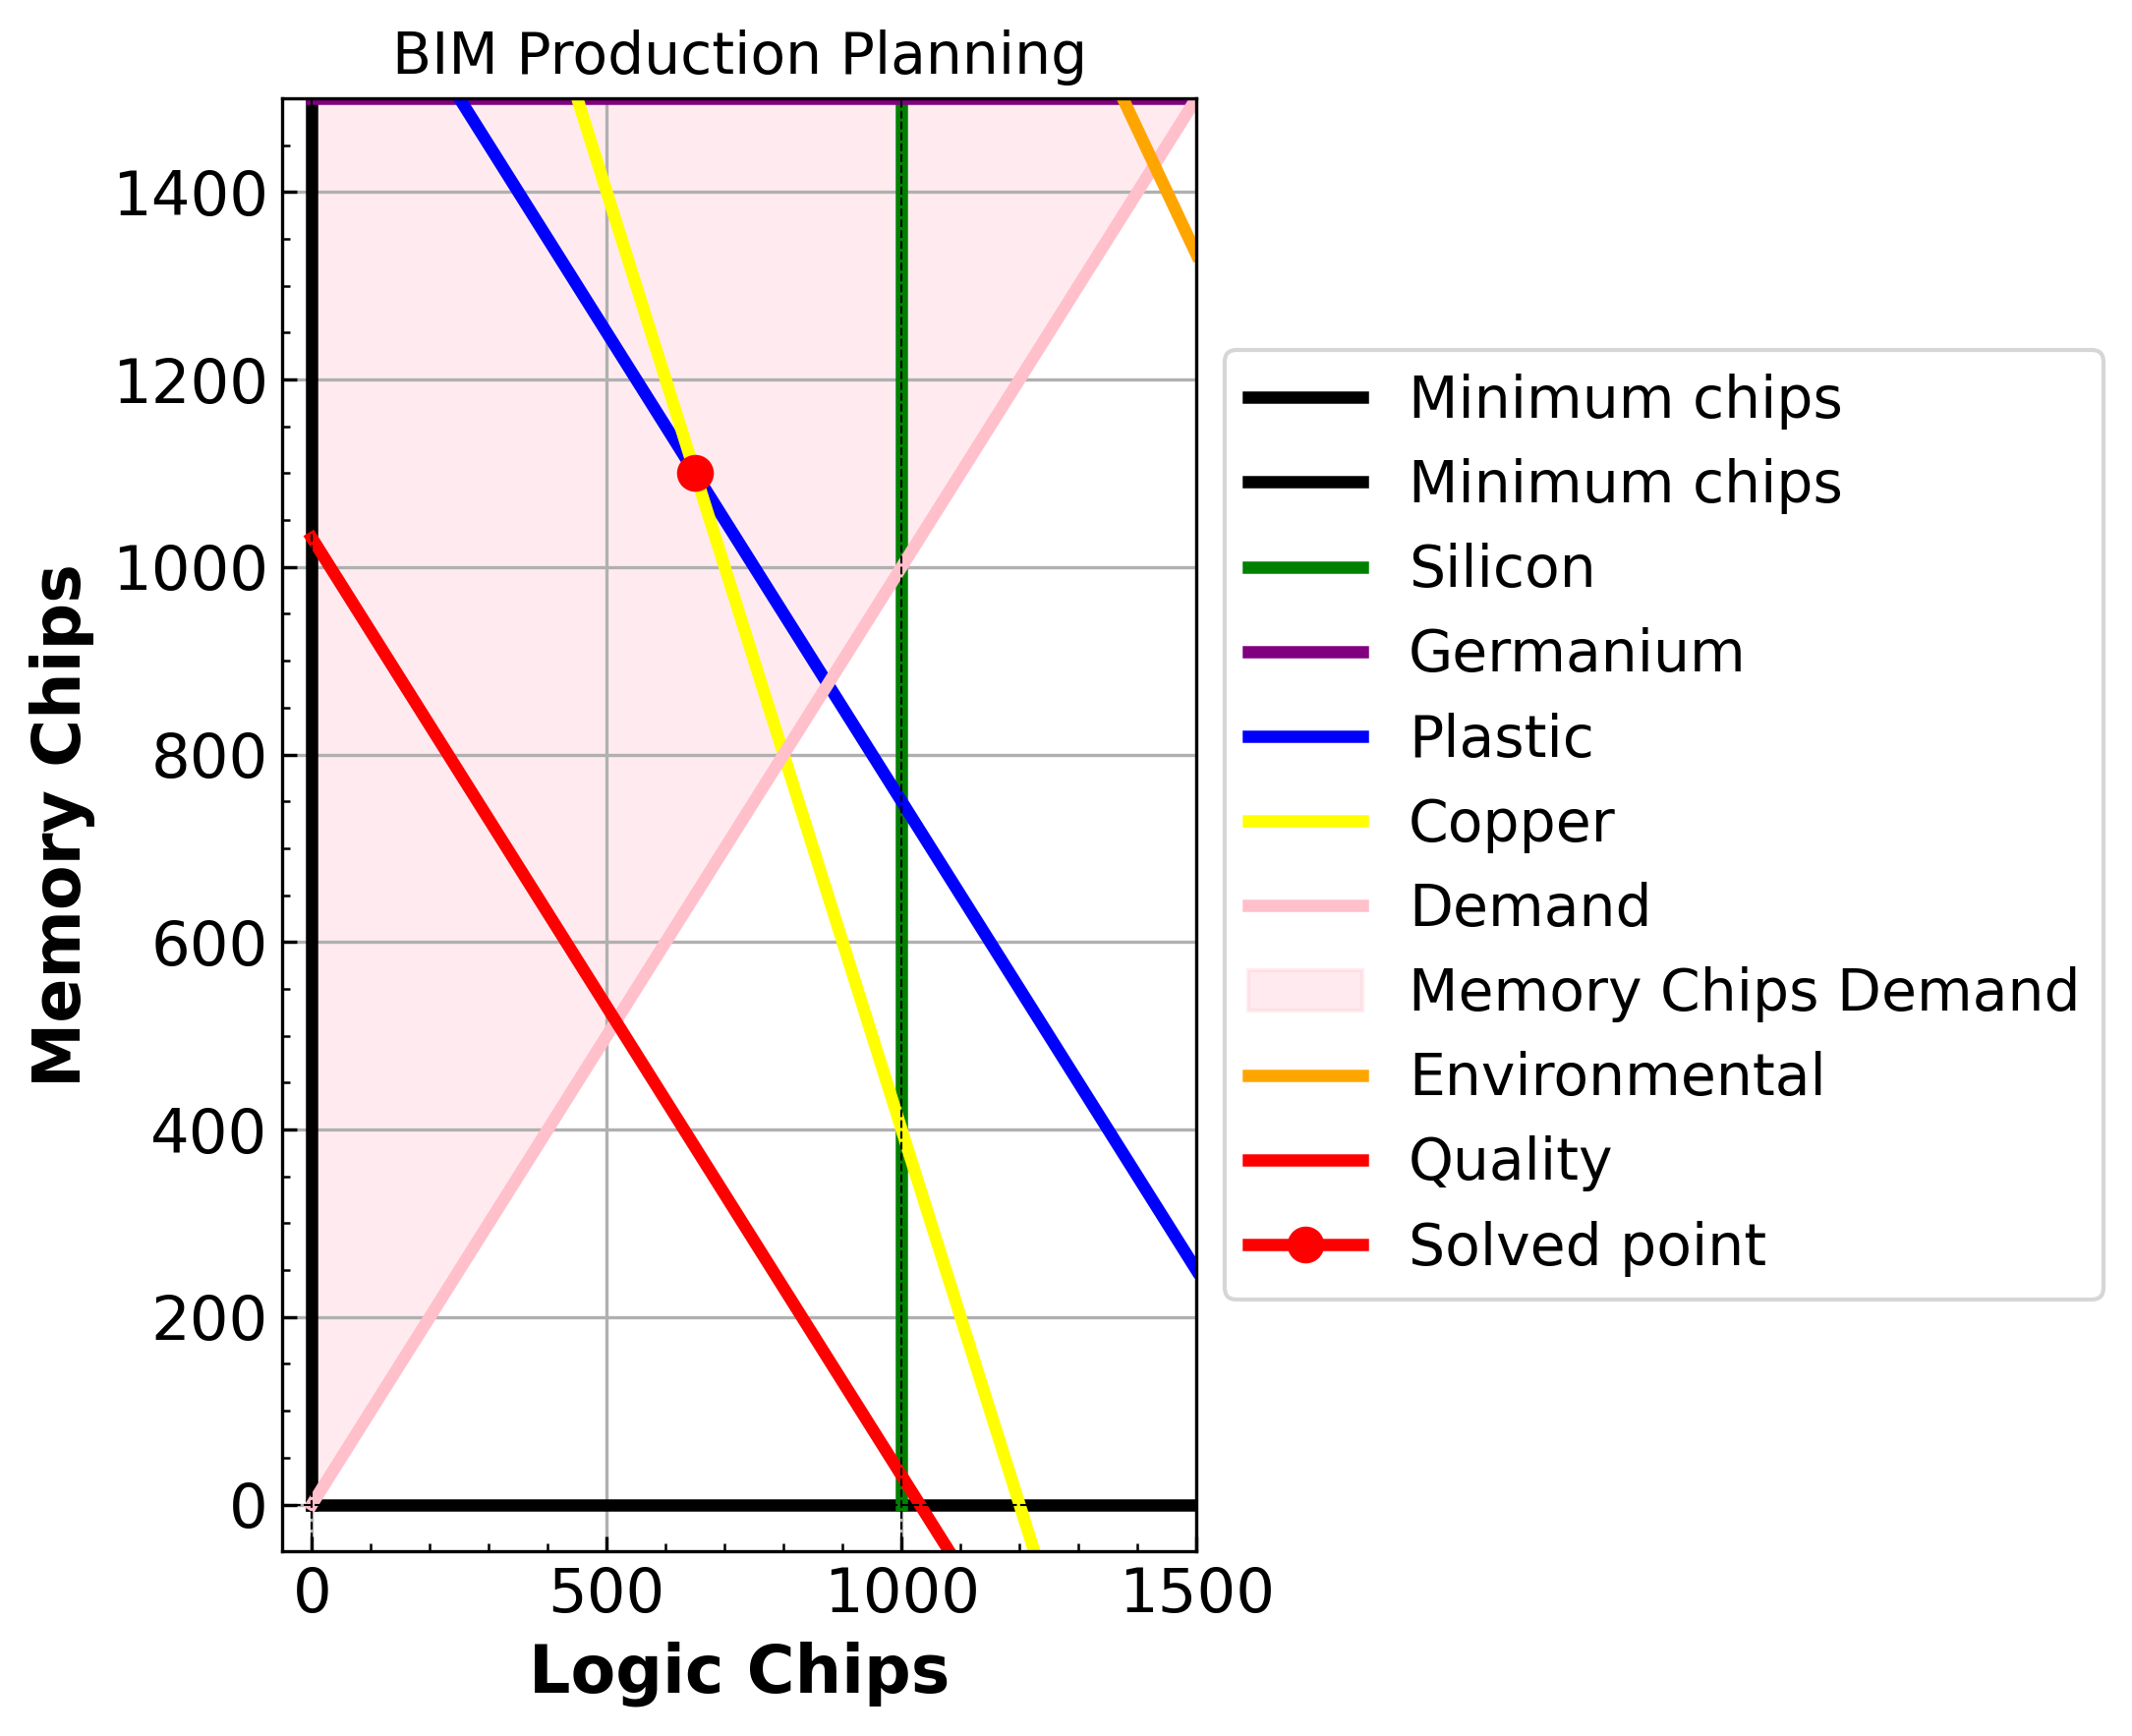

In [ ]:
m_visualize(env_x1=4, env_x2=3, defects=0.97, demand=0)

Demand for logic chips

x = (800.0, 800.0)
Optimal value = 16800.0
Env constraint 1 = 4.0
Env constraint 2 value = 3.0
Demand value = 1.0
Quality value = 1.0


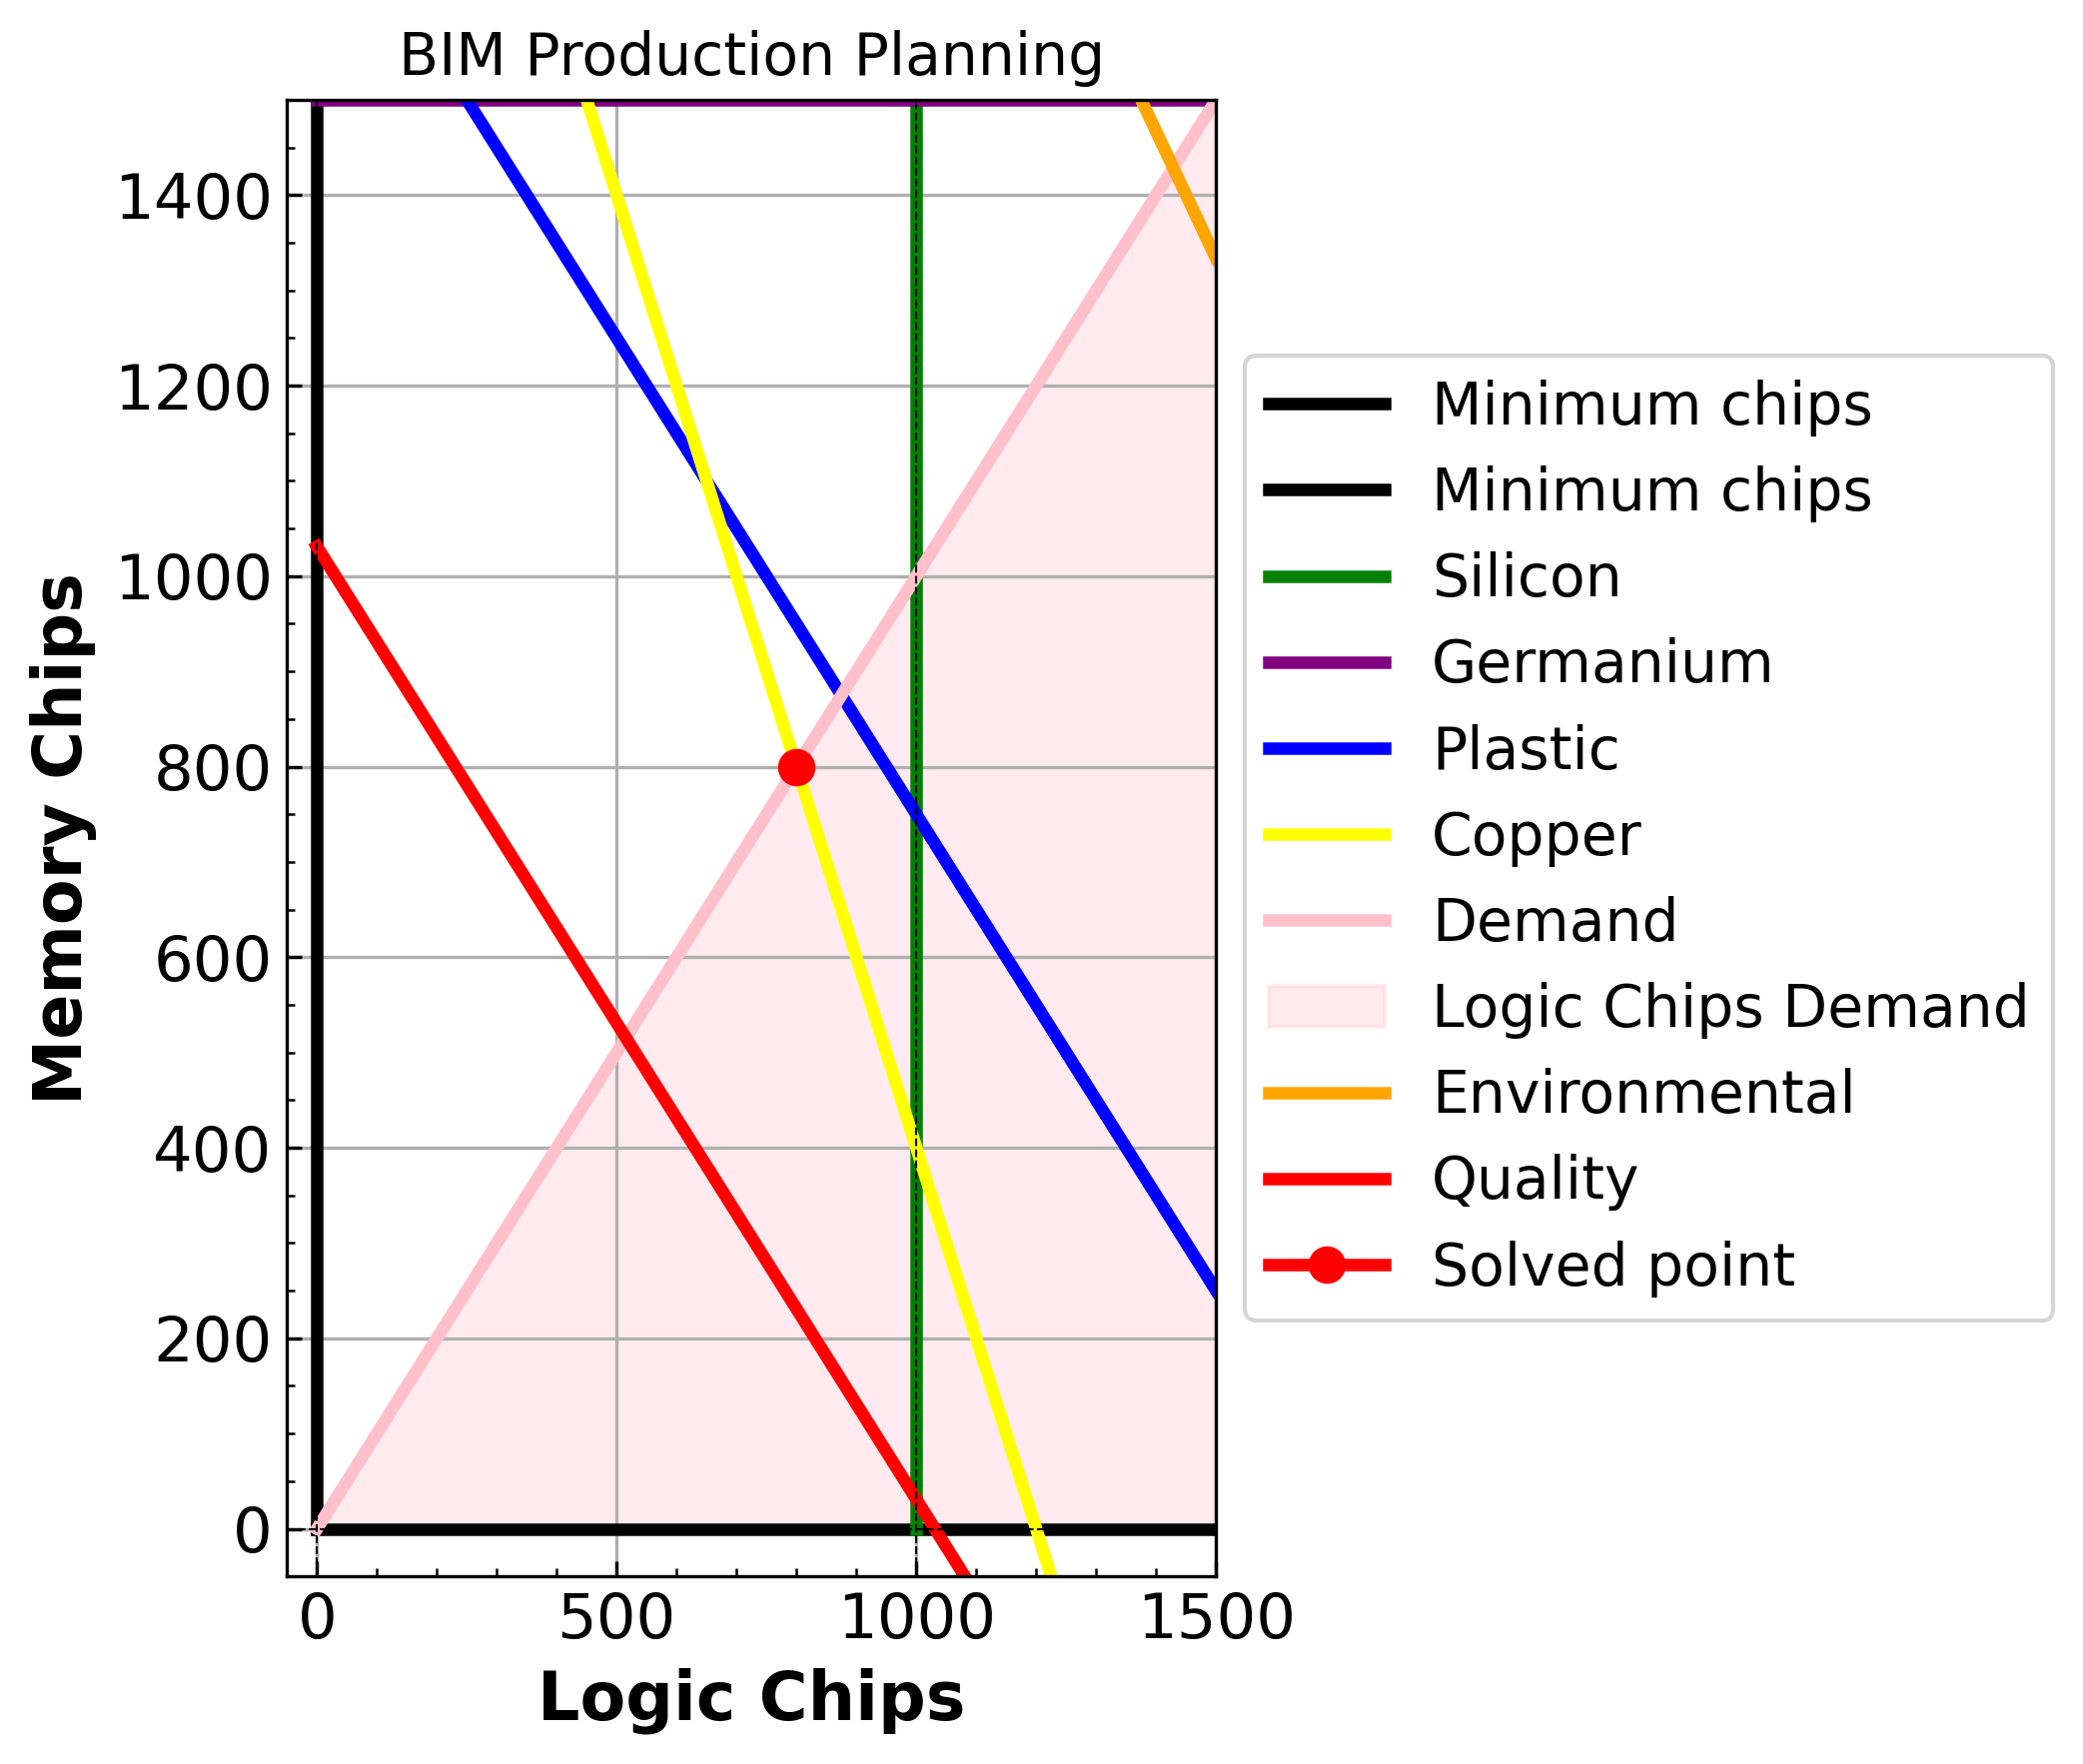

In [ ]:
m_visualize(env_x1=4, env_x2=3, defects=0.97, demand=1)

The demand constraint impacts the amount of total product we can create. It is more advantegeous to create more memory chips as logic chips limits the total amount of supply we can make while still following all the constraints. Further, the demand constraint affects other constraints such as quality.


**Quality Constraint**

Demand for memory chips

x = (650.0, 1100.0)
Optimal value = 17700.0
Env constraint 1 = 3.0
Env constraint 2 value = 4.0
Demand value = 0.0
Quality value = 0.6


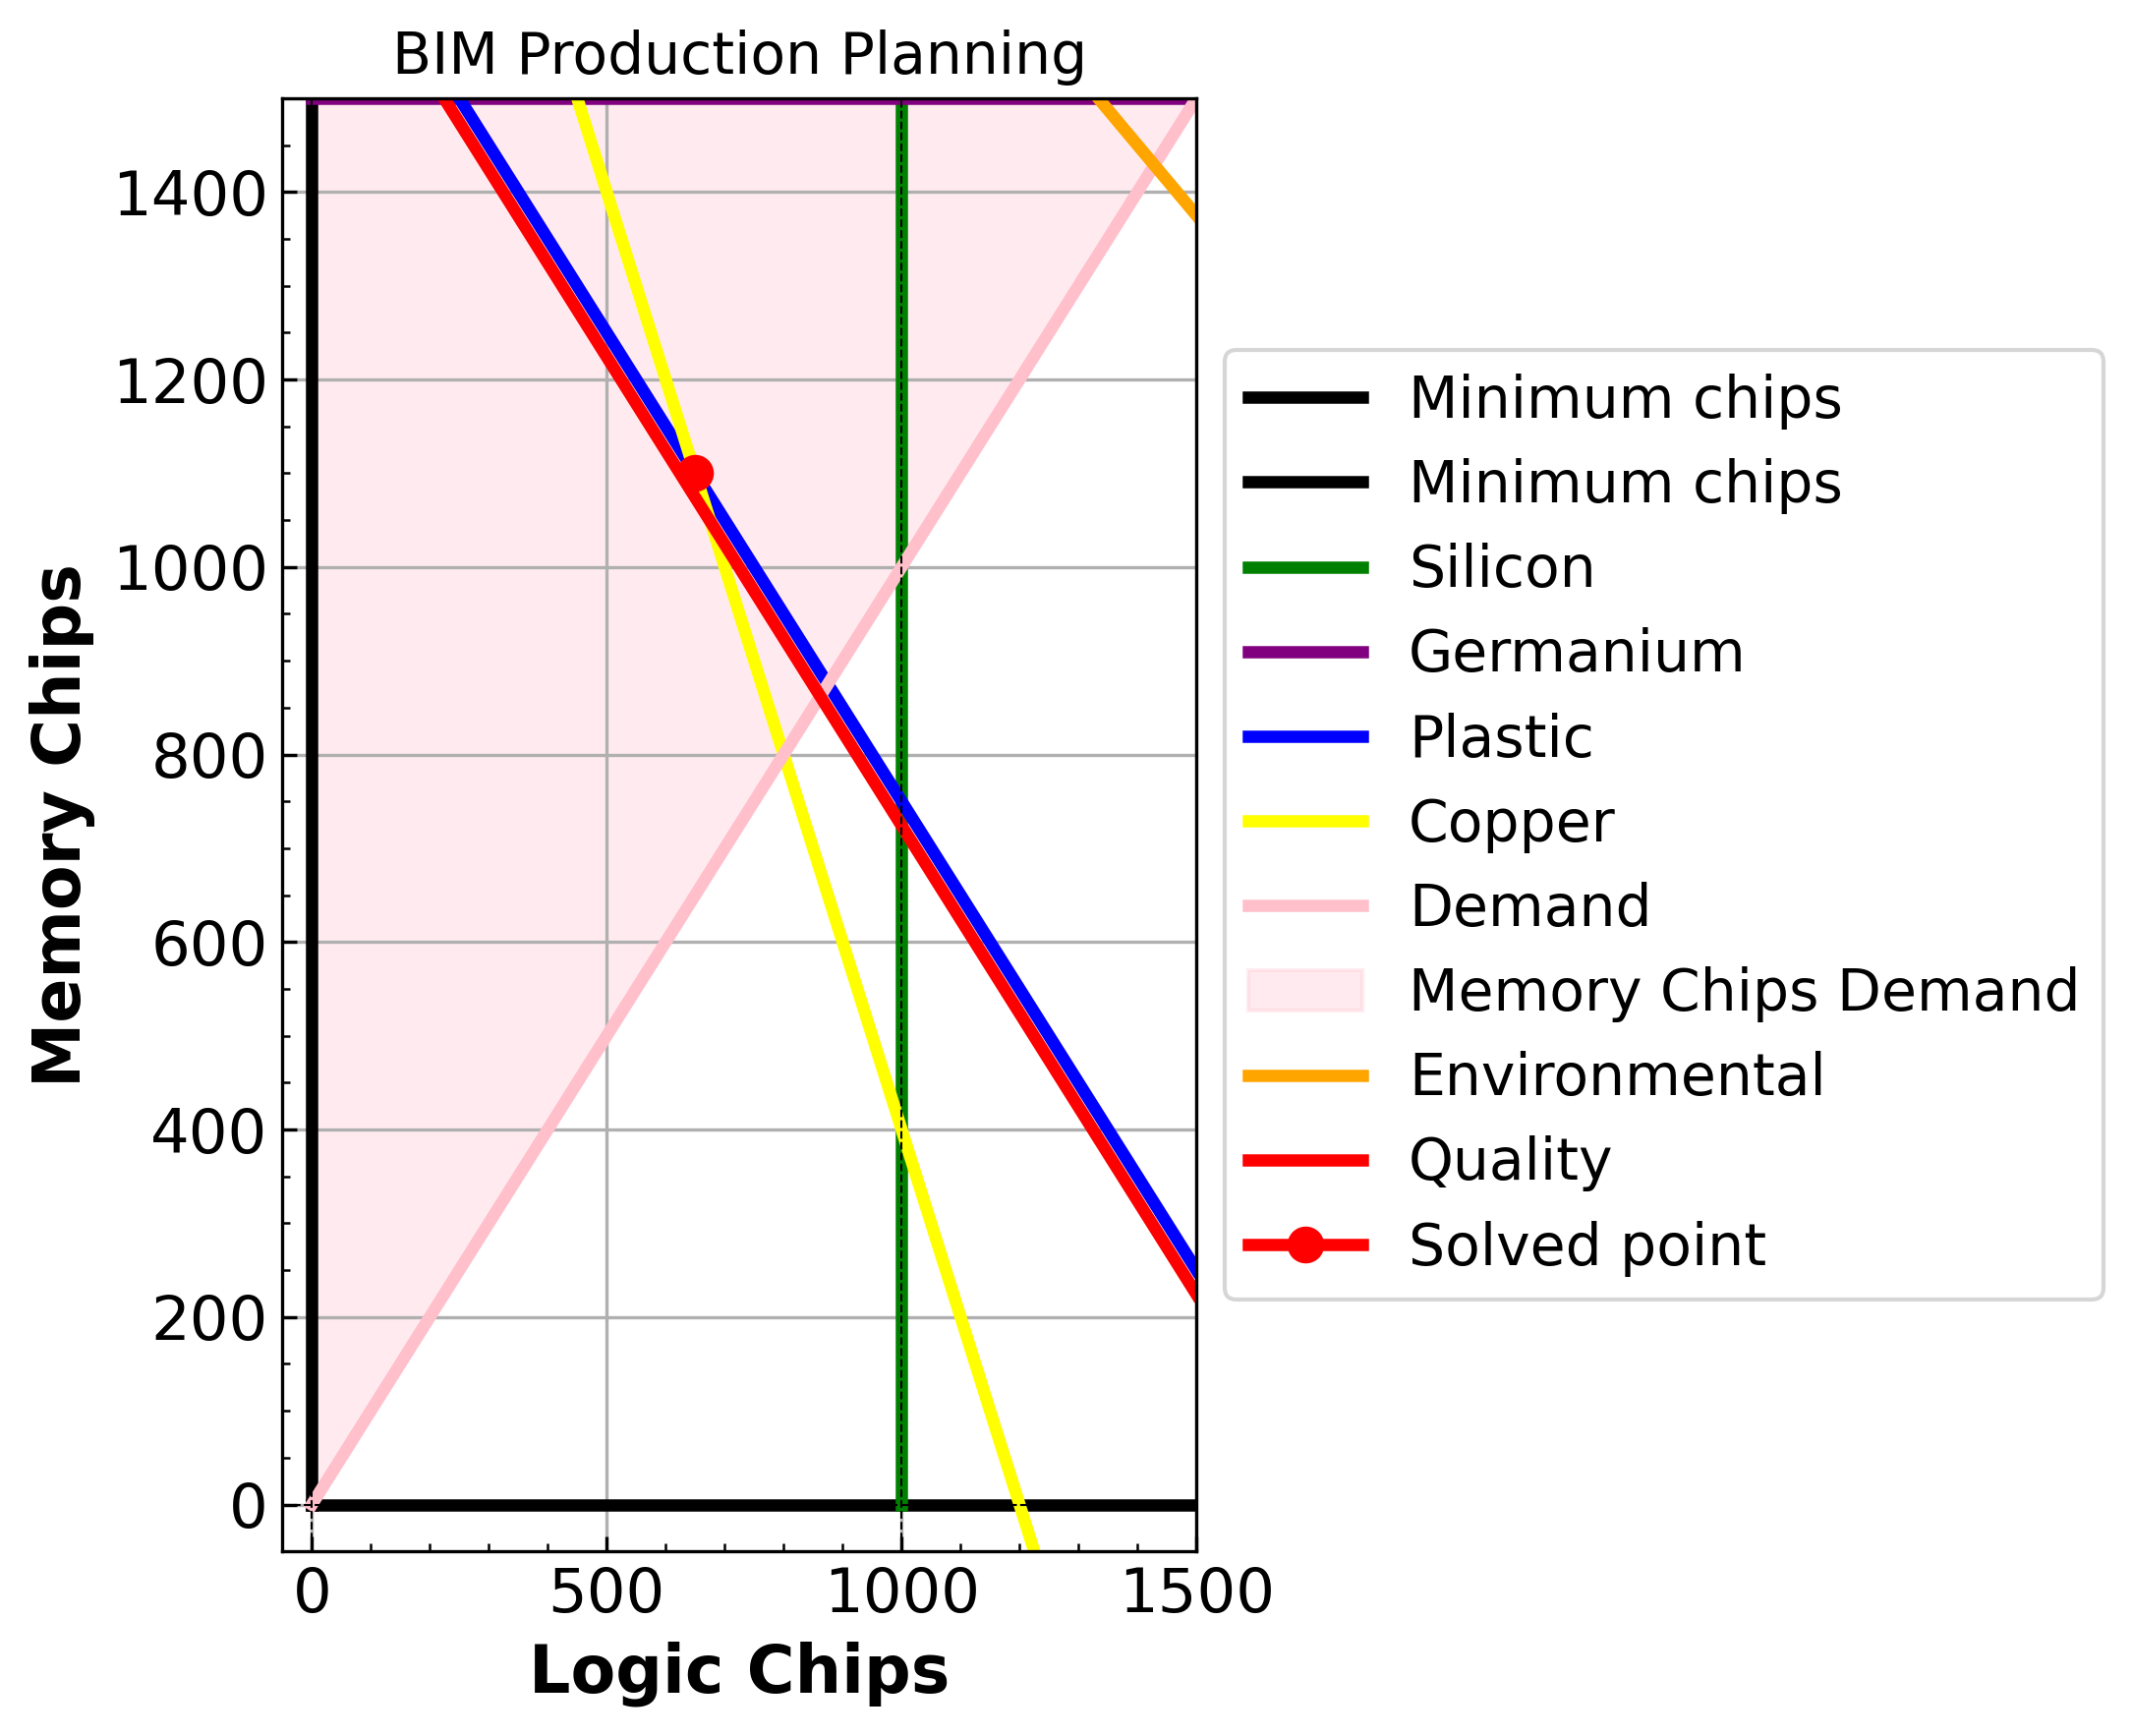

In [ ]:
m_visualize(env_x1=3, env_x2=4, defects=0.58, demand=0)

Demand for memory chips

x = (650.0, 1100.0)
Optimal value = 17700.0
Env constraint 1 = 3.0
Env constraint 2 value = 4.0
Demand value = 0.0
Quality value = 0.9


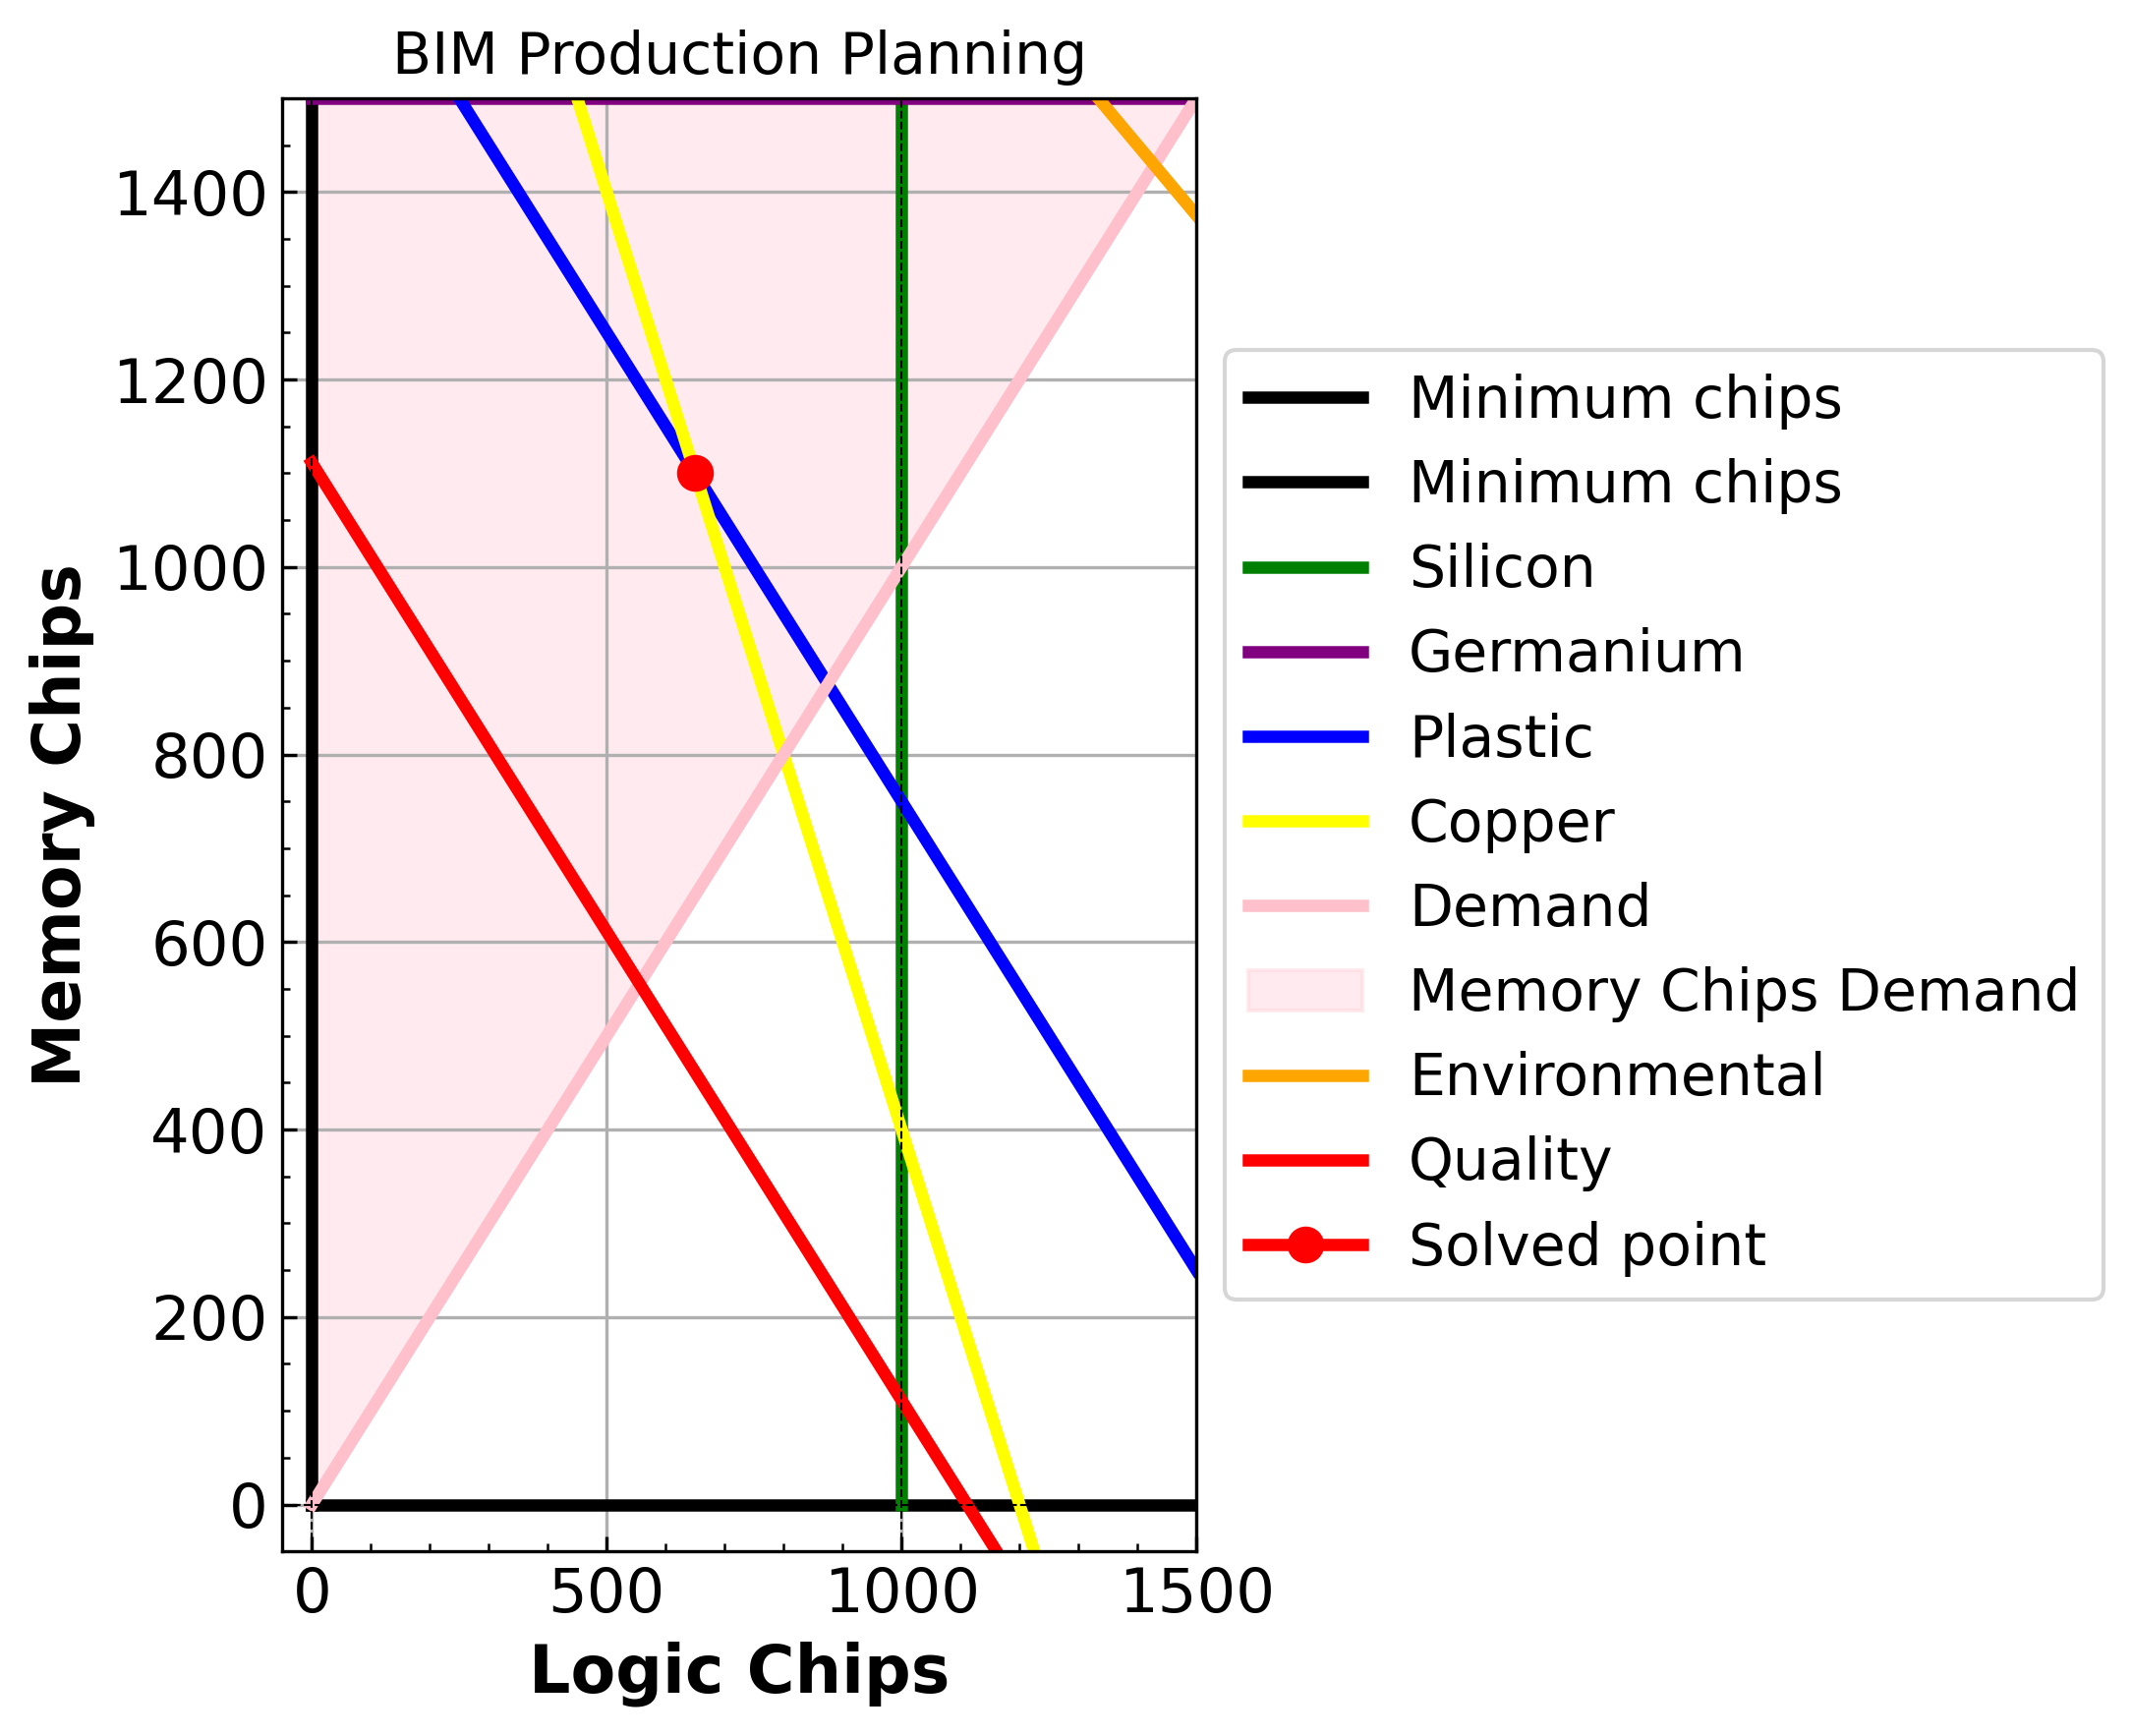

In [ ]:
m_visualize(env_x1=3, env_x2=4, defects=0.9, demand=0)

The system is highly sensitive to the quality control constraint, as seen in the change from 0.5 to 0.9. Increasing the quality chip threshold significantly shifts the feasible region, as shown by the movement of the red line in the graphs. This alters the feasible solution space for chip production. From the movements in the quality constraint line, we learned that memory chips allow more defects than logic chips, offering greater flexibility when buyer demand shifts toward them. This offers the insight, combineed with the above buyer demand constraint, that when memory chips are more popular, this company will have higher profits.
